In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib.pyplot import figure
from sklearn.metrics import f1_score, confusion_matrix, roc_auc_score, recall_score, precision_score
import numpy as np
import statistics

In [2]:
def calculate_score(data_frame, score_type, no_sensors):
    """
    :param data_frame: Complete Dataframe
    :param no_sensors: Number of Sensors in Dataframe
    :param start_time: Start point. Value from time column
    :param max_delta: Number of samples. max_time = (no_samples * (time between two samples))
    :param step_size: It is the number of samples added to current time_delta to get next time_delta
    :return:
    """
    labels_pred = data_frame.iloc[:, (4 * no_sensors) + 2:(5 * no_sensors) + 2]
    labels_true = data_frame["status"].values
    
    result_score = np.zeros((no_sensors))

    for sensor in range(no_sensors):
        anomaly_pred = labels_pred.iloc[:, sensor].values
        if score_type == "f1_score":
            result = f1_score(labels_true, anomaly_pred, average="binary")
            index_names = ["f1 sensor_" + str(i) for i in range(no_sensors)]
        elif score_type == "precision_score":
            result = precision_score(labels_true, anomaly_pred, average="binary")
            index_names = ["precision sensor_" + str(i) for i in range(no_sensors)]
        elif score_type == "recall_score":
            result = recall_score(labels_true, anomaly_pred, average="binary")
            index_names = ["recall sensor_" + str(i) for i in range(no_sensors)]
        else:
            result = 0
            index_names = ["error" for i in range(no_sensors)]
            
        result_score[sensor] = result

    score_df = pd.Series(data=result_score, index=index_names)
    return score_df

In [3]:
def visualise_metric_per_sensor(results, title):
    fig, axes = plt.subplots(results.shape[1]-1, 1, figsize=(10,20),constrained_layout=False)
    ax = axes.ravel()
    t = results.loc[:,"delta_t"]
    columns = results.columns
    for i in range(results.shape[1]-1): 
        sns.lineplot(data=results, 
                     x=t, 
                     y=columns[i], 
                     ax=ax[i],
                     linewidth=1,
                     color="black")
        ax[i].set_xlabel("delta t [in samples]")
    plt.tight_layout()
    plt.subplots_adjust(top=0.95)
    plt.suptitle(title, fontsize=16)

In [4]:
def visualise_metric_machine(results, score_type, phase):
    t = results.loc[:,"delta_t"]
    complete_title = "CPPS Data - Beginning of Phase '{}''".format(phase)
    
    # Caluculate Metric for hole machine (sum over sensors and devide by no_sensors)
    labels = results.drop(columns="delta_t", axis=0)
    result_machine = labels.sum(axis=1) / results.shape[1]
    
    # Visualise Results
    sns.lineplot(x=t, 
                 y=result_machine, 
                 linewidth=1,
                 color="black")
    plt.xlabel("delta t [in samples]")
    plt.ylabel("{} over all dim".format(score_type))
    #plt.tight_layout()
    plt.title(complete_title, fontsize=16, y=1.12)

In [5]:
def vis_cumulative_detection(dataframe, no_features, first_feature, last_feature, location_line1, location_line2, subset):
    fig, axes = plt.subplots(subset, 1, figsize=(10,6), dpi=200)
    ax = axes.ravel()
    columns = dataframe.columns
    t = dataframe.iloc[:,0]
    for i in range(first_feature, last_feature):
        sns.lineplot(data=dataframe, 
                     x=t, 
                     y=dataframe.iloc[:, i+4*no_features+1].cumsum(),
                     ax=ax[i-first_feature],
                     color="blue",)
        ax[i-first_feature].set_ylim(0, 5000) 
        ax[i-first_feature].axvline(location_line1, color="r", linestyle ="--", linewidth=2)
        ax[i-first_feature].axvline(location_line2, color="r", linestyle ="--", linewidth=2)
        ax[i-first_feature].text(7000, 4000, "Phase 1: No Error", fontsize=10)
        ax[i-first_feature].text(25000, 4000, "Phase 2: Small Error", fontsize=10)
        ax[i-first_feature].text(41000, 1000, "Phase 3: Large Error", fontsize=10)
        
        # Legend etc. 
        ax[i-1].set_xlabel("time [in s]")
        ax[i-1].set_ylabel("Cumulative sum")
        ax[i-1].set_title("Sensor No.{}".format(i))

In [6]:
def get_confusion_matrix_machine(data_frame, no_sensors):
    
    tp = []
    fp = []
    tn = []
    fn = []
    for i in range(0,no_sensors):
        labels_pred = data_frame.iloc[:, (4 * no_sensors)+i+2].values
        labels_true = data_frame["status"].values
        
        tn_sensor, fp_sensor, fn_sensor, tp_sensor = confusion_matrix(labels_true, labels_pred).ravel()
        tp.append(tp_sensor)
        fp.append(fp_sensor)
        tn.append(tn_sensor)
        fn.append(fn_sensor)
    
    return tp, fp, tn, fn

In [7]:
def vis_anomaly_detection(dataframe, no_features, first_feature, last_feature, failures, line, training):
    fig, axes = plt.subplots(no_features, 1, figsize=(30,40))
    ax = axes.ravel()
    columns = dataframe.columns
    t = dataframe["up time"]
    for i in range(first_feature, last_feature):
        sns.lineplot(data=dataframe, 
                     x=t, 
                     y=dataframe.iloc[:, i+4*no_features+1].cumsum(),
                     ax=ax[i-first_feature],
                     color="blue",)
        
        # Plot line for last training sample
        if training:
            ax[i-1].axvspan(3283834,3523830, alpha=0.2, color='green')
        
        # Plot line for failure points
        if line:
            for failure in failures:
                ax[i-first_feature].axvline(failure, 0,2, color="r", linestyle ="--", linewidth=2)
        
        # Set y-limit
        ax[i-first_feature].set_ylim(0,15000)

# Evaluation Prediction Interval
## Setup

In [13]:
all_data = pd.read_csv("../../files/classification/MLE/phm_67_SQ36_3sigma.csv", sep=";")
until_first_failure = all_data.loc[all_data["up time"]<=3807966]

In [14]:
all_failures_67 =[3807966., 3814610., 3815890., 3816362., 3856686., 3860122., 3865202., 3867646., 3868170.,
       3870094., 6539522., 6549554., 6572426., 6573162., 6574566., 6575118., 6575566., 6577254., 6582502., 6586022.]

# Model Evaluation
### F1 Score 

In [15]:
score = calculate_score(until_first_failure, "f1_score", 12)
print(score[0])

0.6978894121751265


### Confusion Matrix

In [11]:
print("Positive --> Anomaly")
print("Negative --> Normal Behaviour")
print("--"*15)
tp, fp, tn, fn = get_confusion_matrix_machine(until_first_failure, 12)
print("True negative: {}".format(tn[0]))
print("False positive: {}".format(fp[0]))
print("False negative: {}".format(fn[0]))
print("True positive: {}".format(tp[0]))

Positive --> Anomaly
Negative --> Normal Behaviour
------------------------------
True negative: 53148
False positive: 4308
False negative: 2620
True positive: 8002


## Sensetivity

In [12]:
print(tn[0] / (tn[0] + fp[0]))

0.9250208855472013


### Cumulative Sum of Anomaly, labeld by LSTM-Model

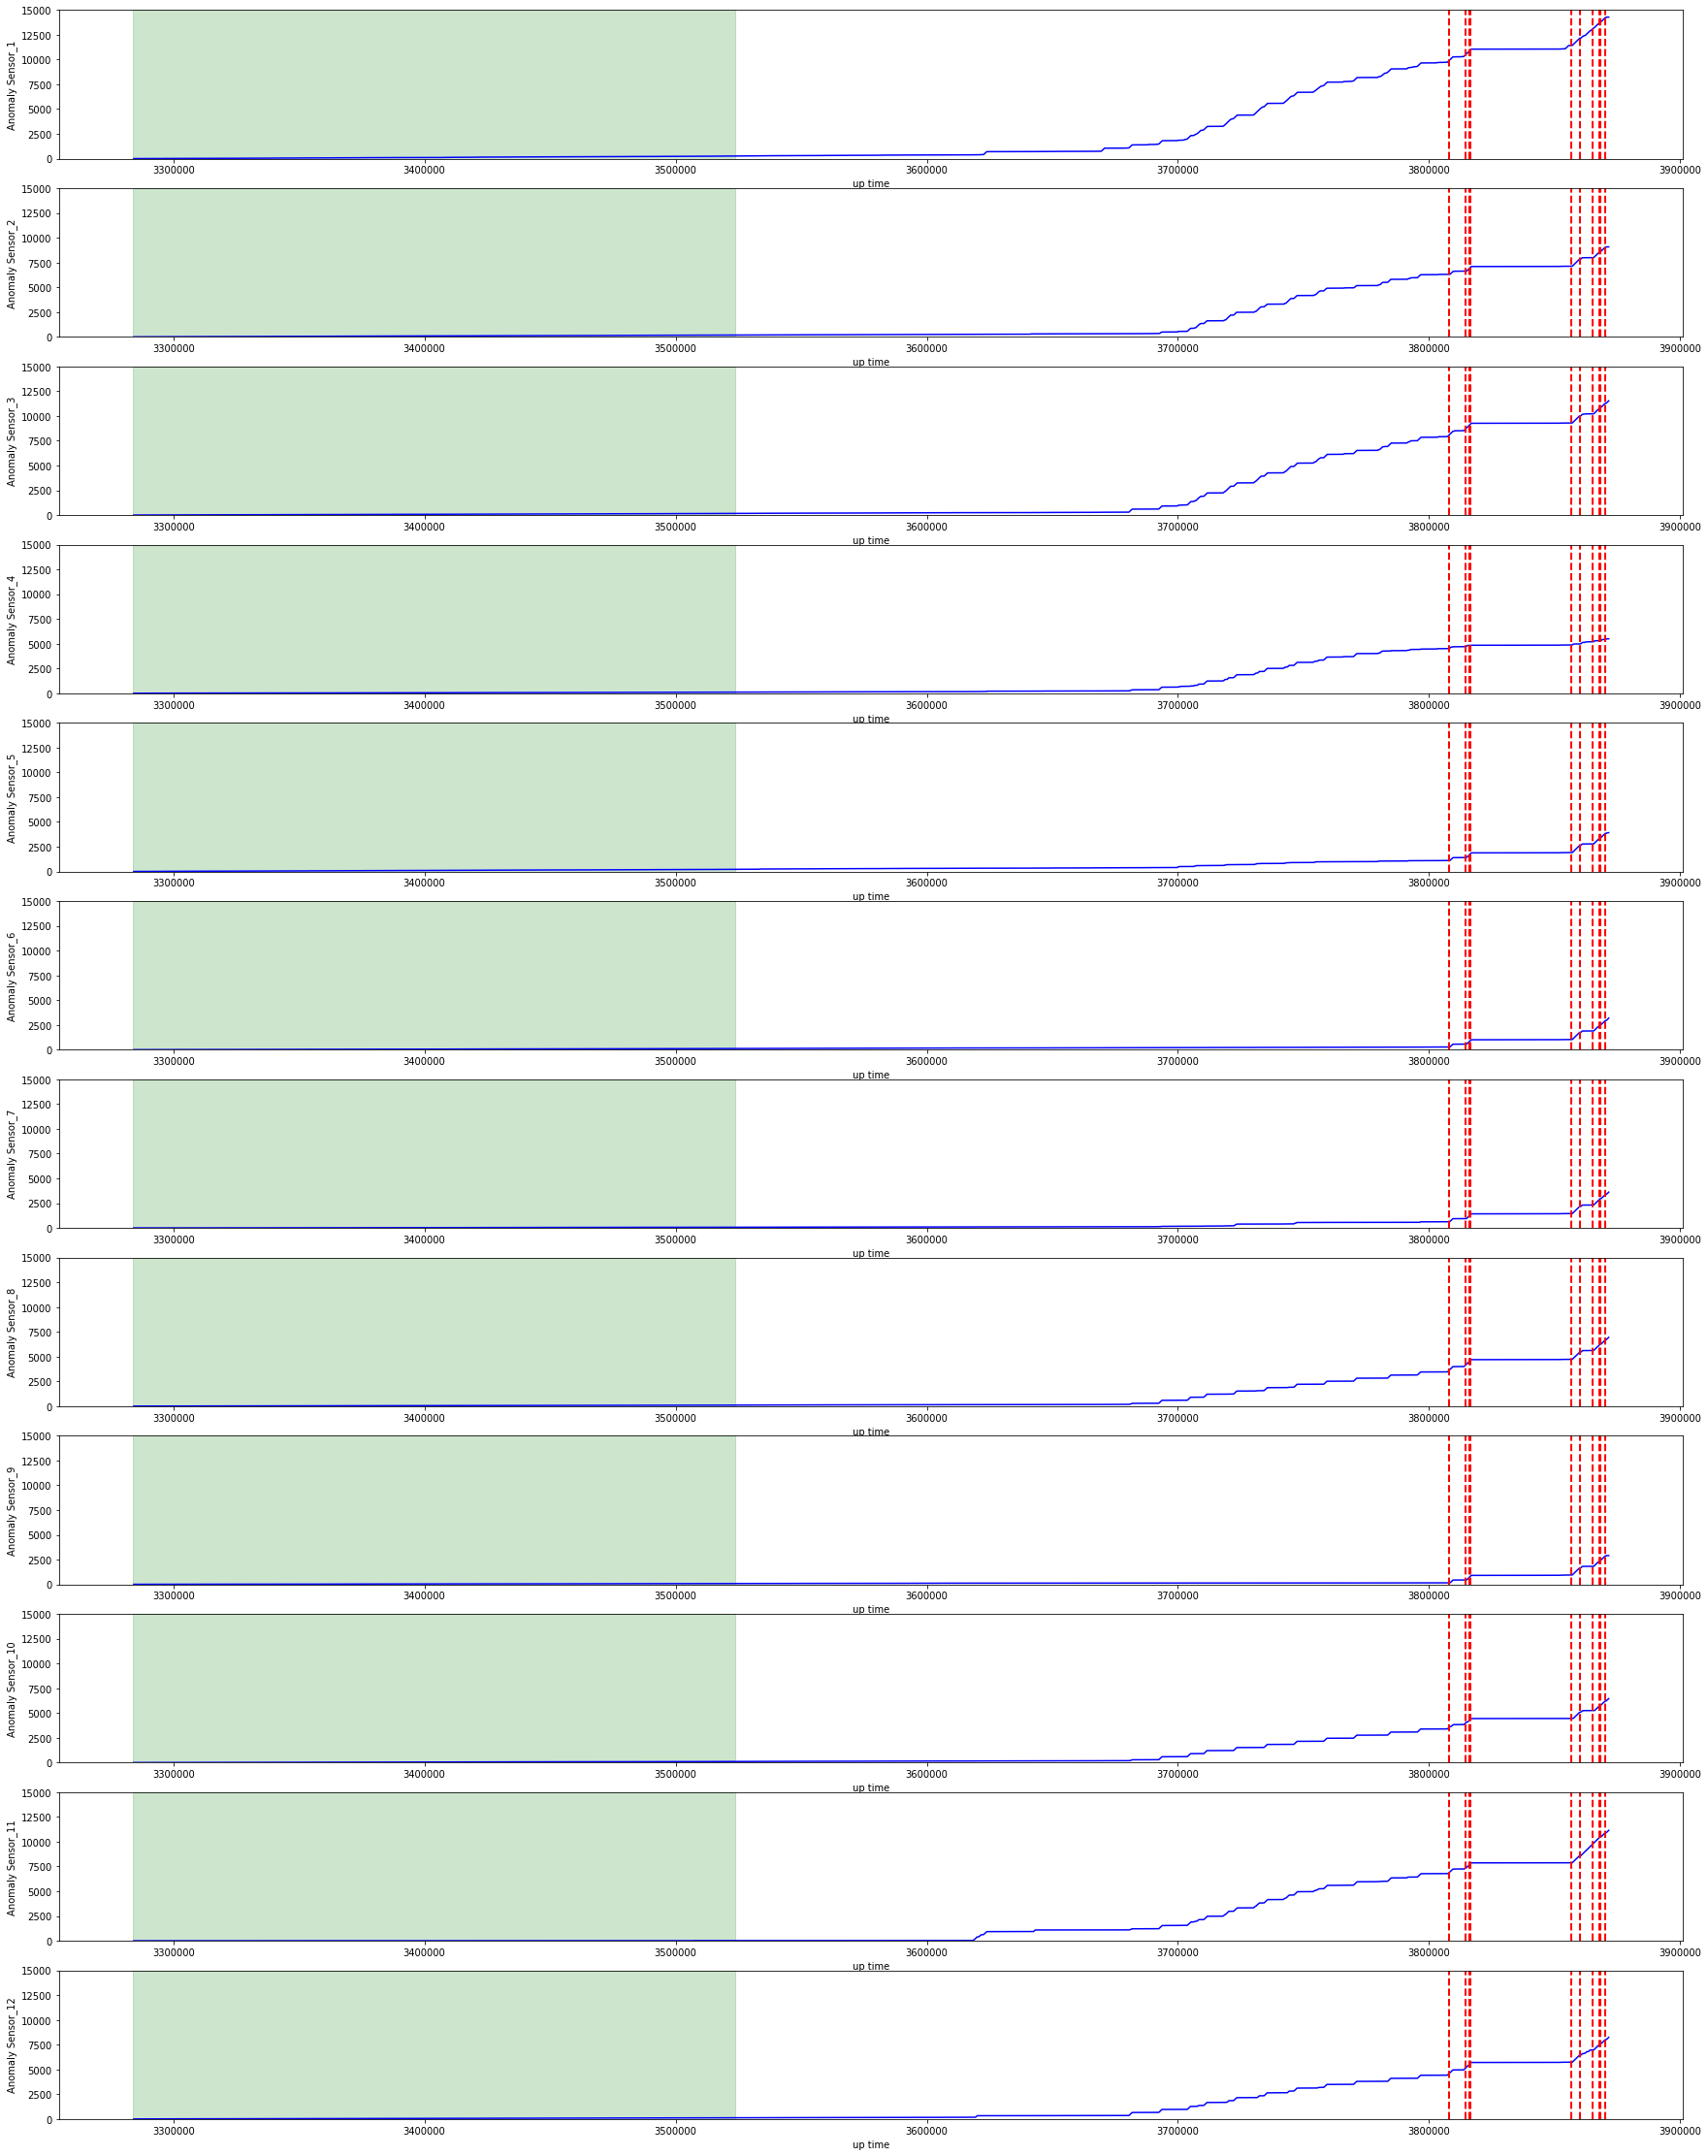

In [103]:
subset_1 = all_data.iloc[0:75000,:]
failures_67_subset1 =[3807966., 3814610., 3815890., 3816362., 3856686., 3860122., 3865202., 3867646., 3868170., 3870094.]
vis_anomaly_detection(subset_1, 12, 1, 13, failures_67_subset1, line=True, training=True)
plt.show()

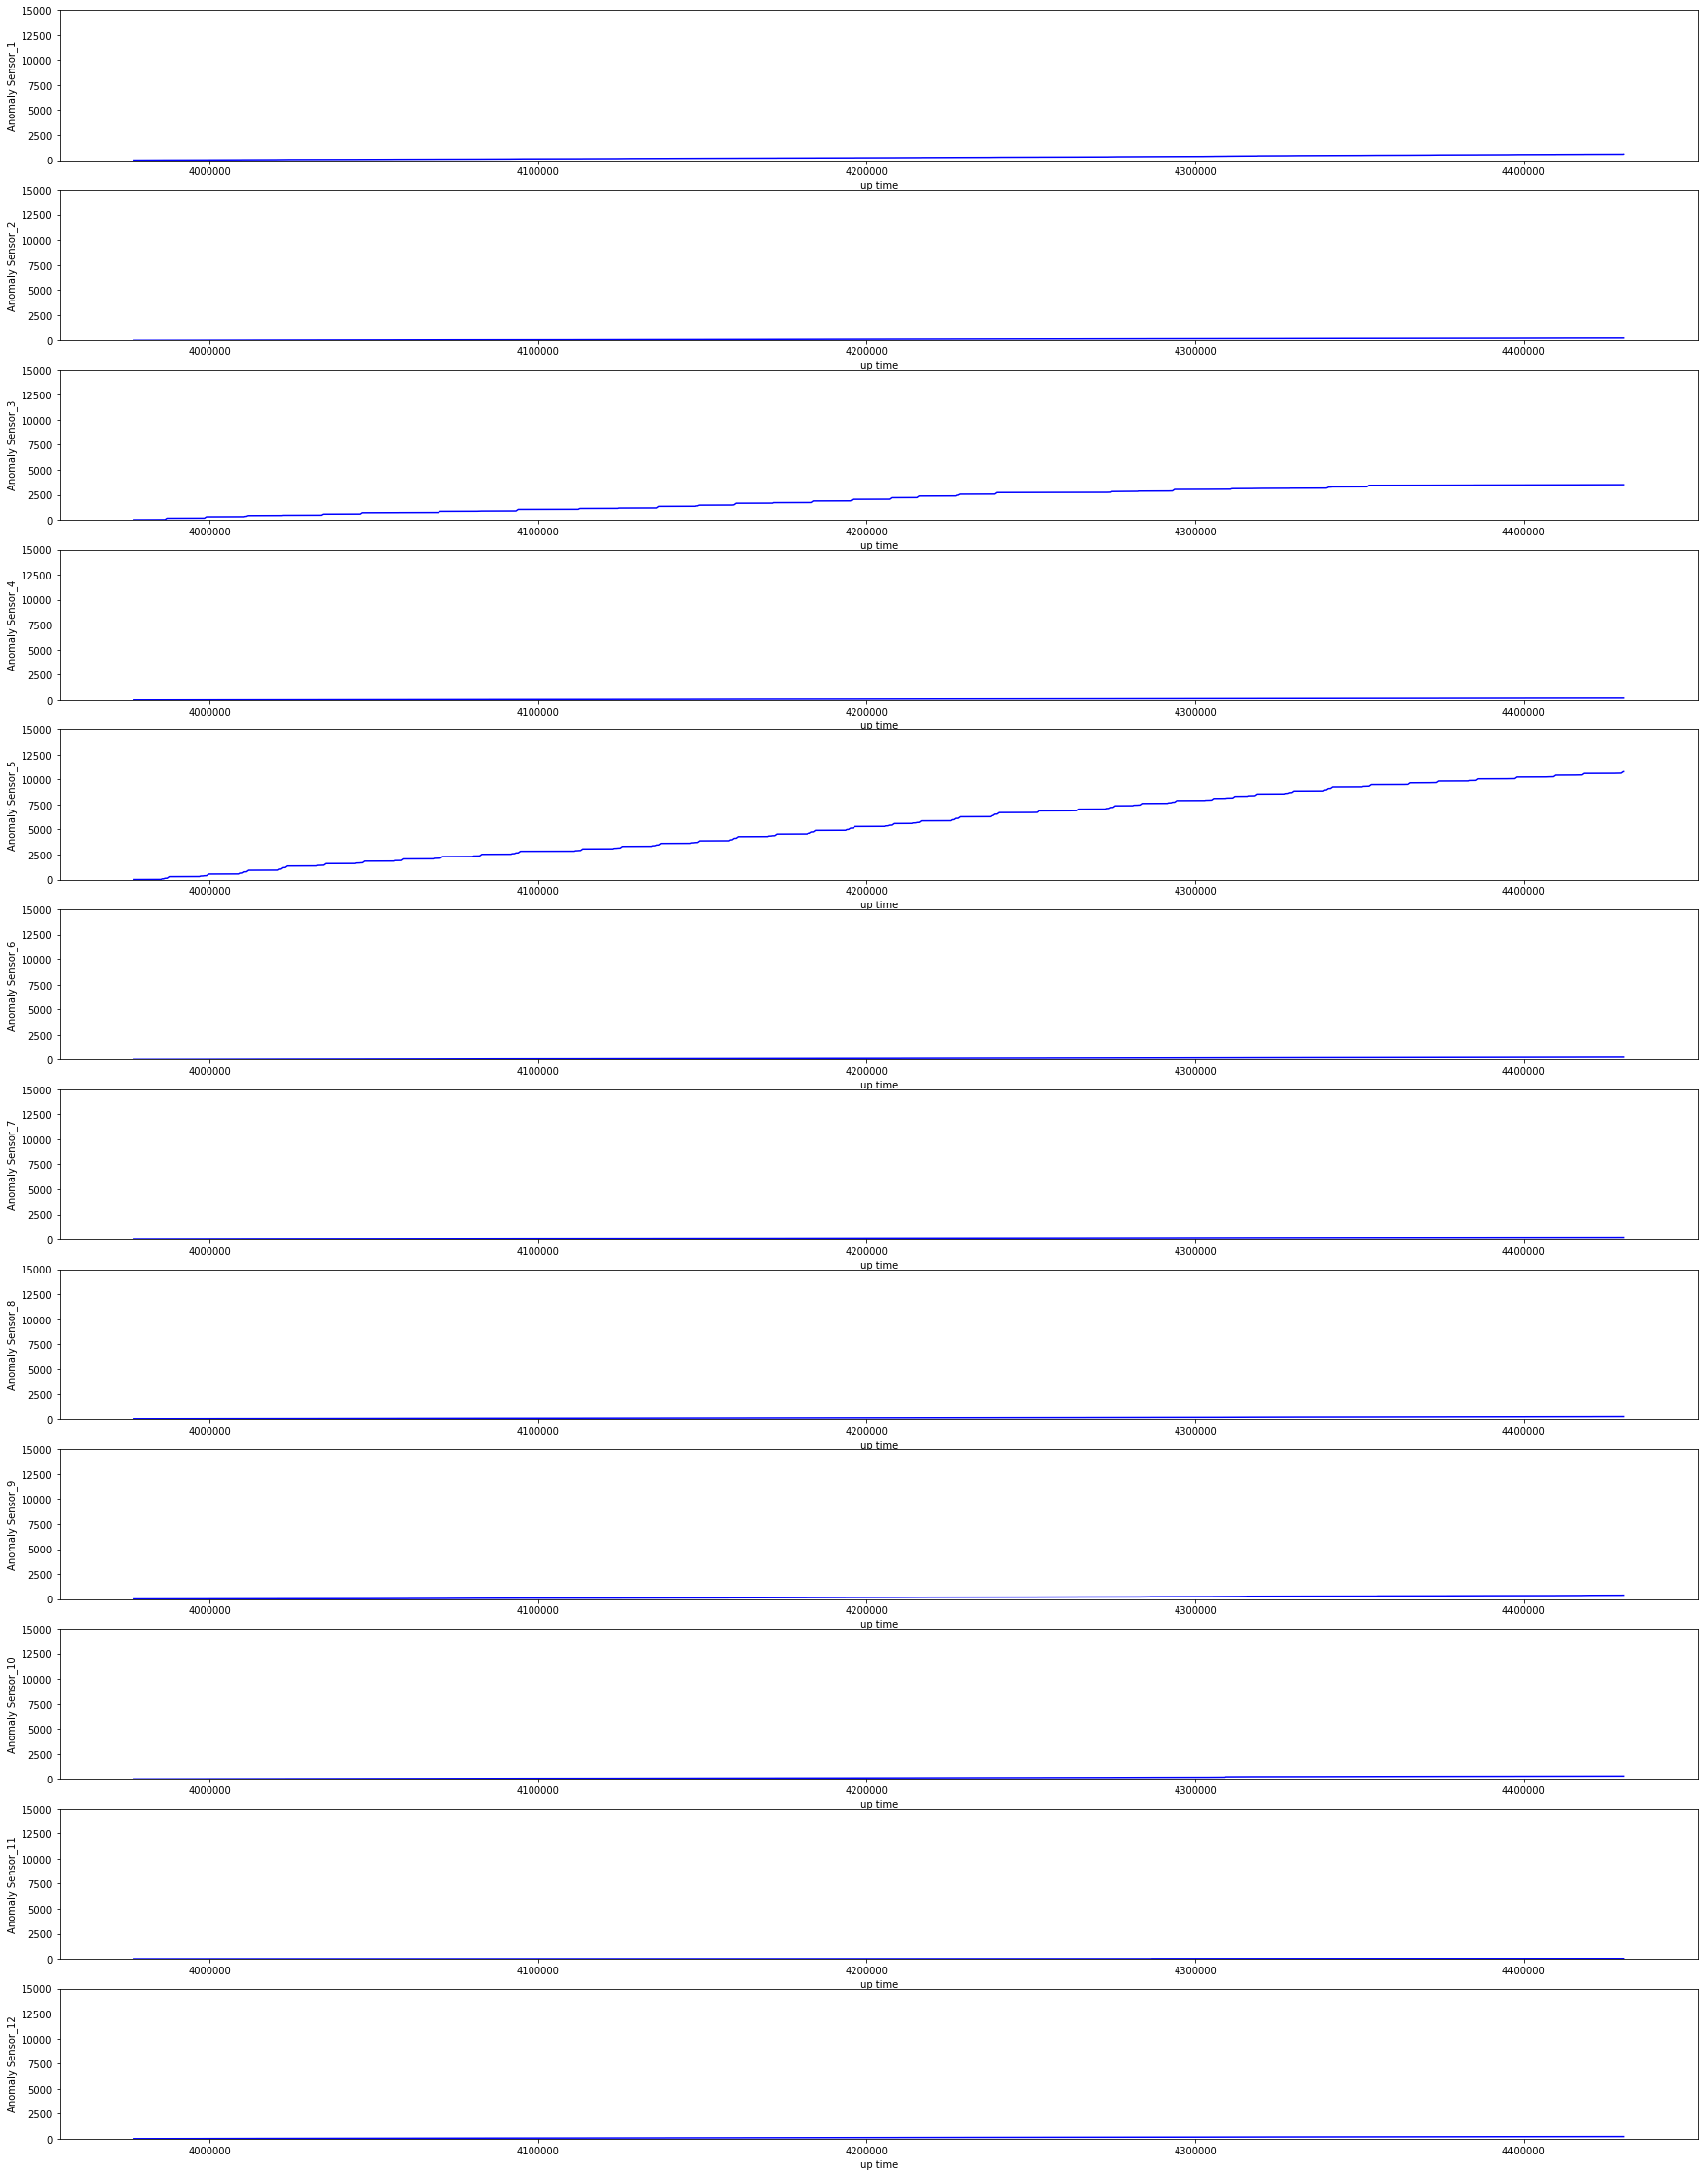

In [104]:
subset_2 = artifical_data.iloc[90000:150000,:]
vis_anomaly_detection(subset_2, 12, 1, 13, failures_67_subset1, line=False, training=False)
plt.show()

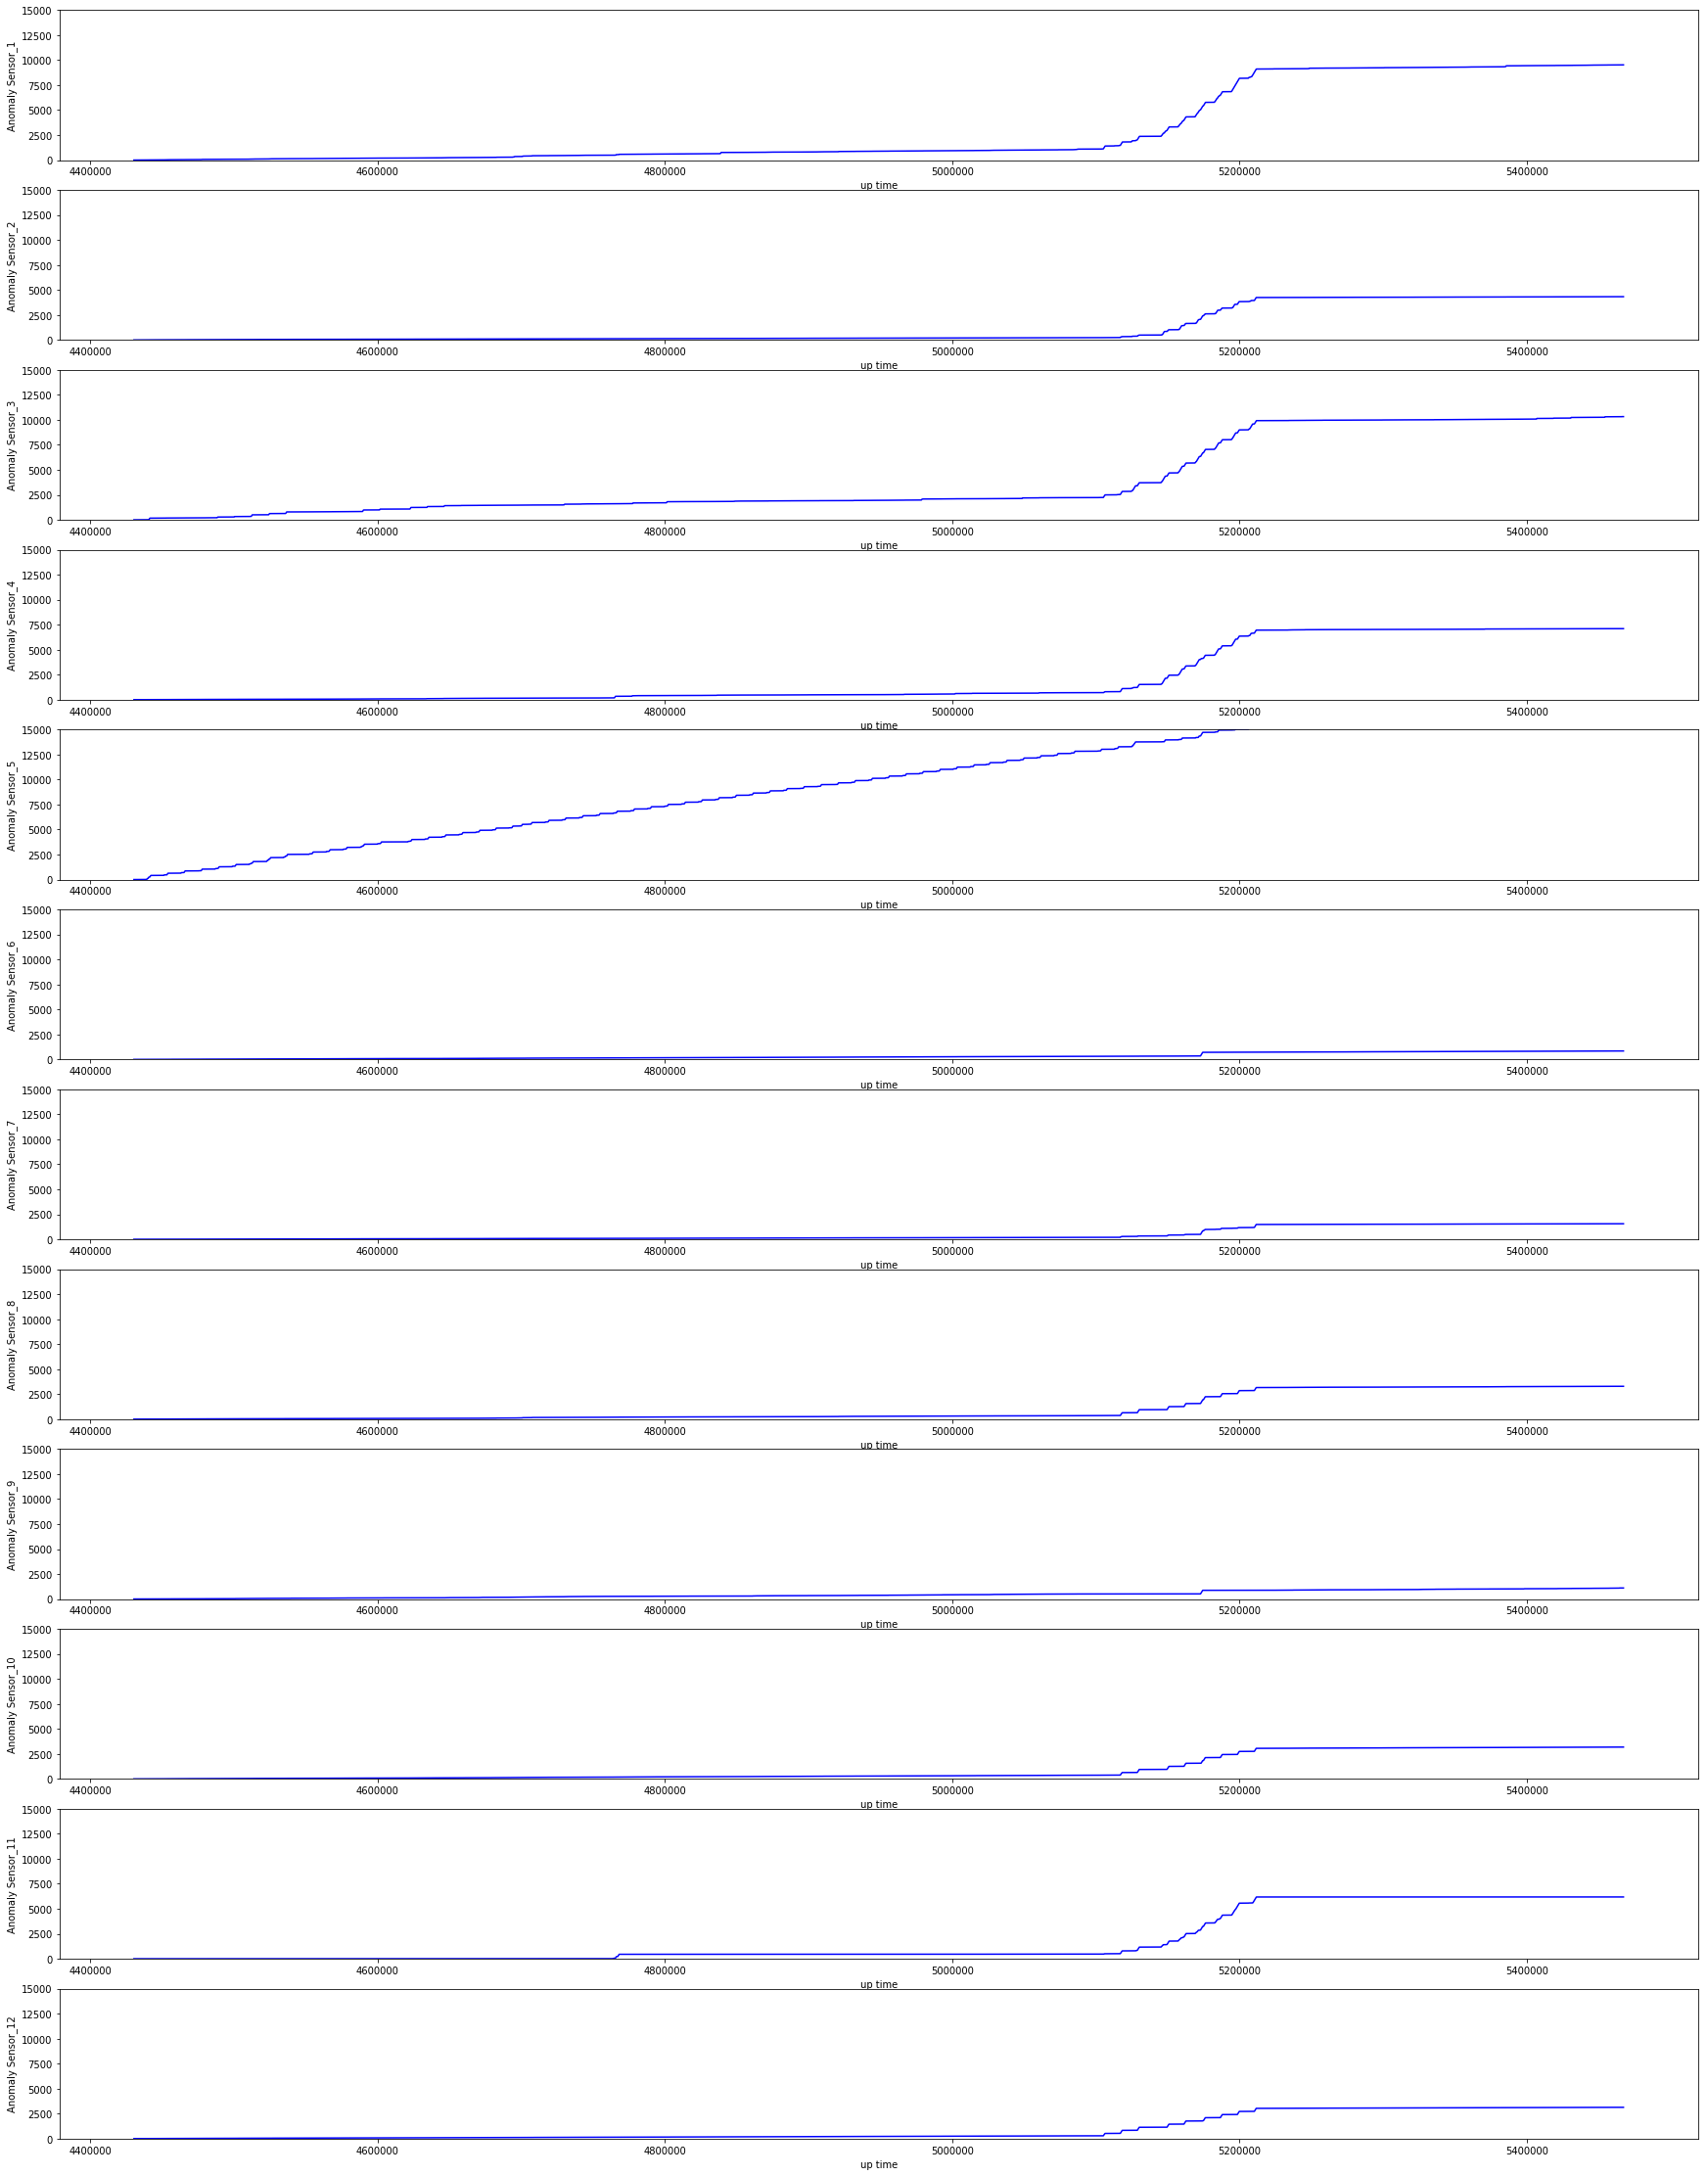

In [9]:
subset_3 = artifical_data.iloc[150000:280000,:]
failures_67_subset3 = [5200500]
vis_anomaly_detection(subset_3, 12, 1, 13, failures_67_subset3, line=False, training=False)
plt.show()

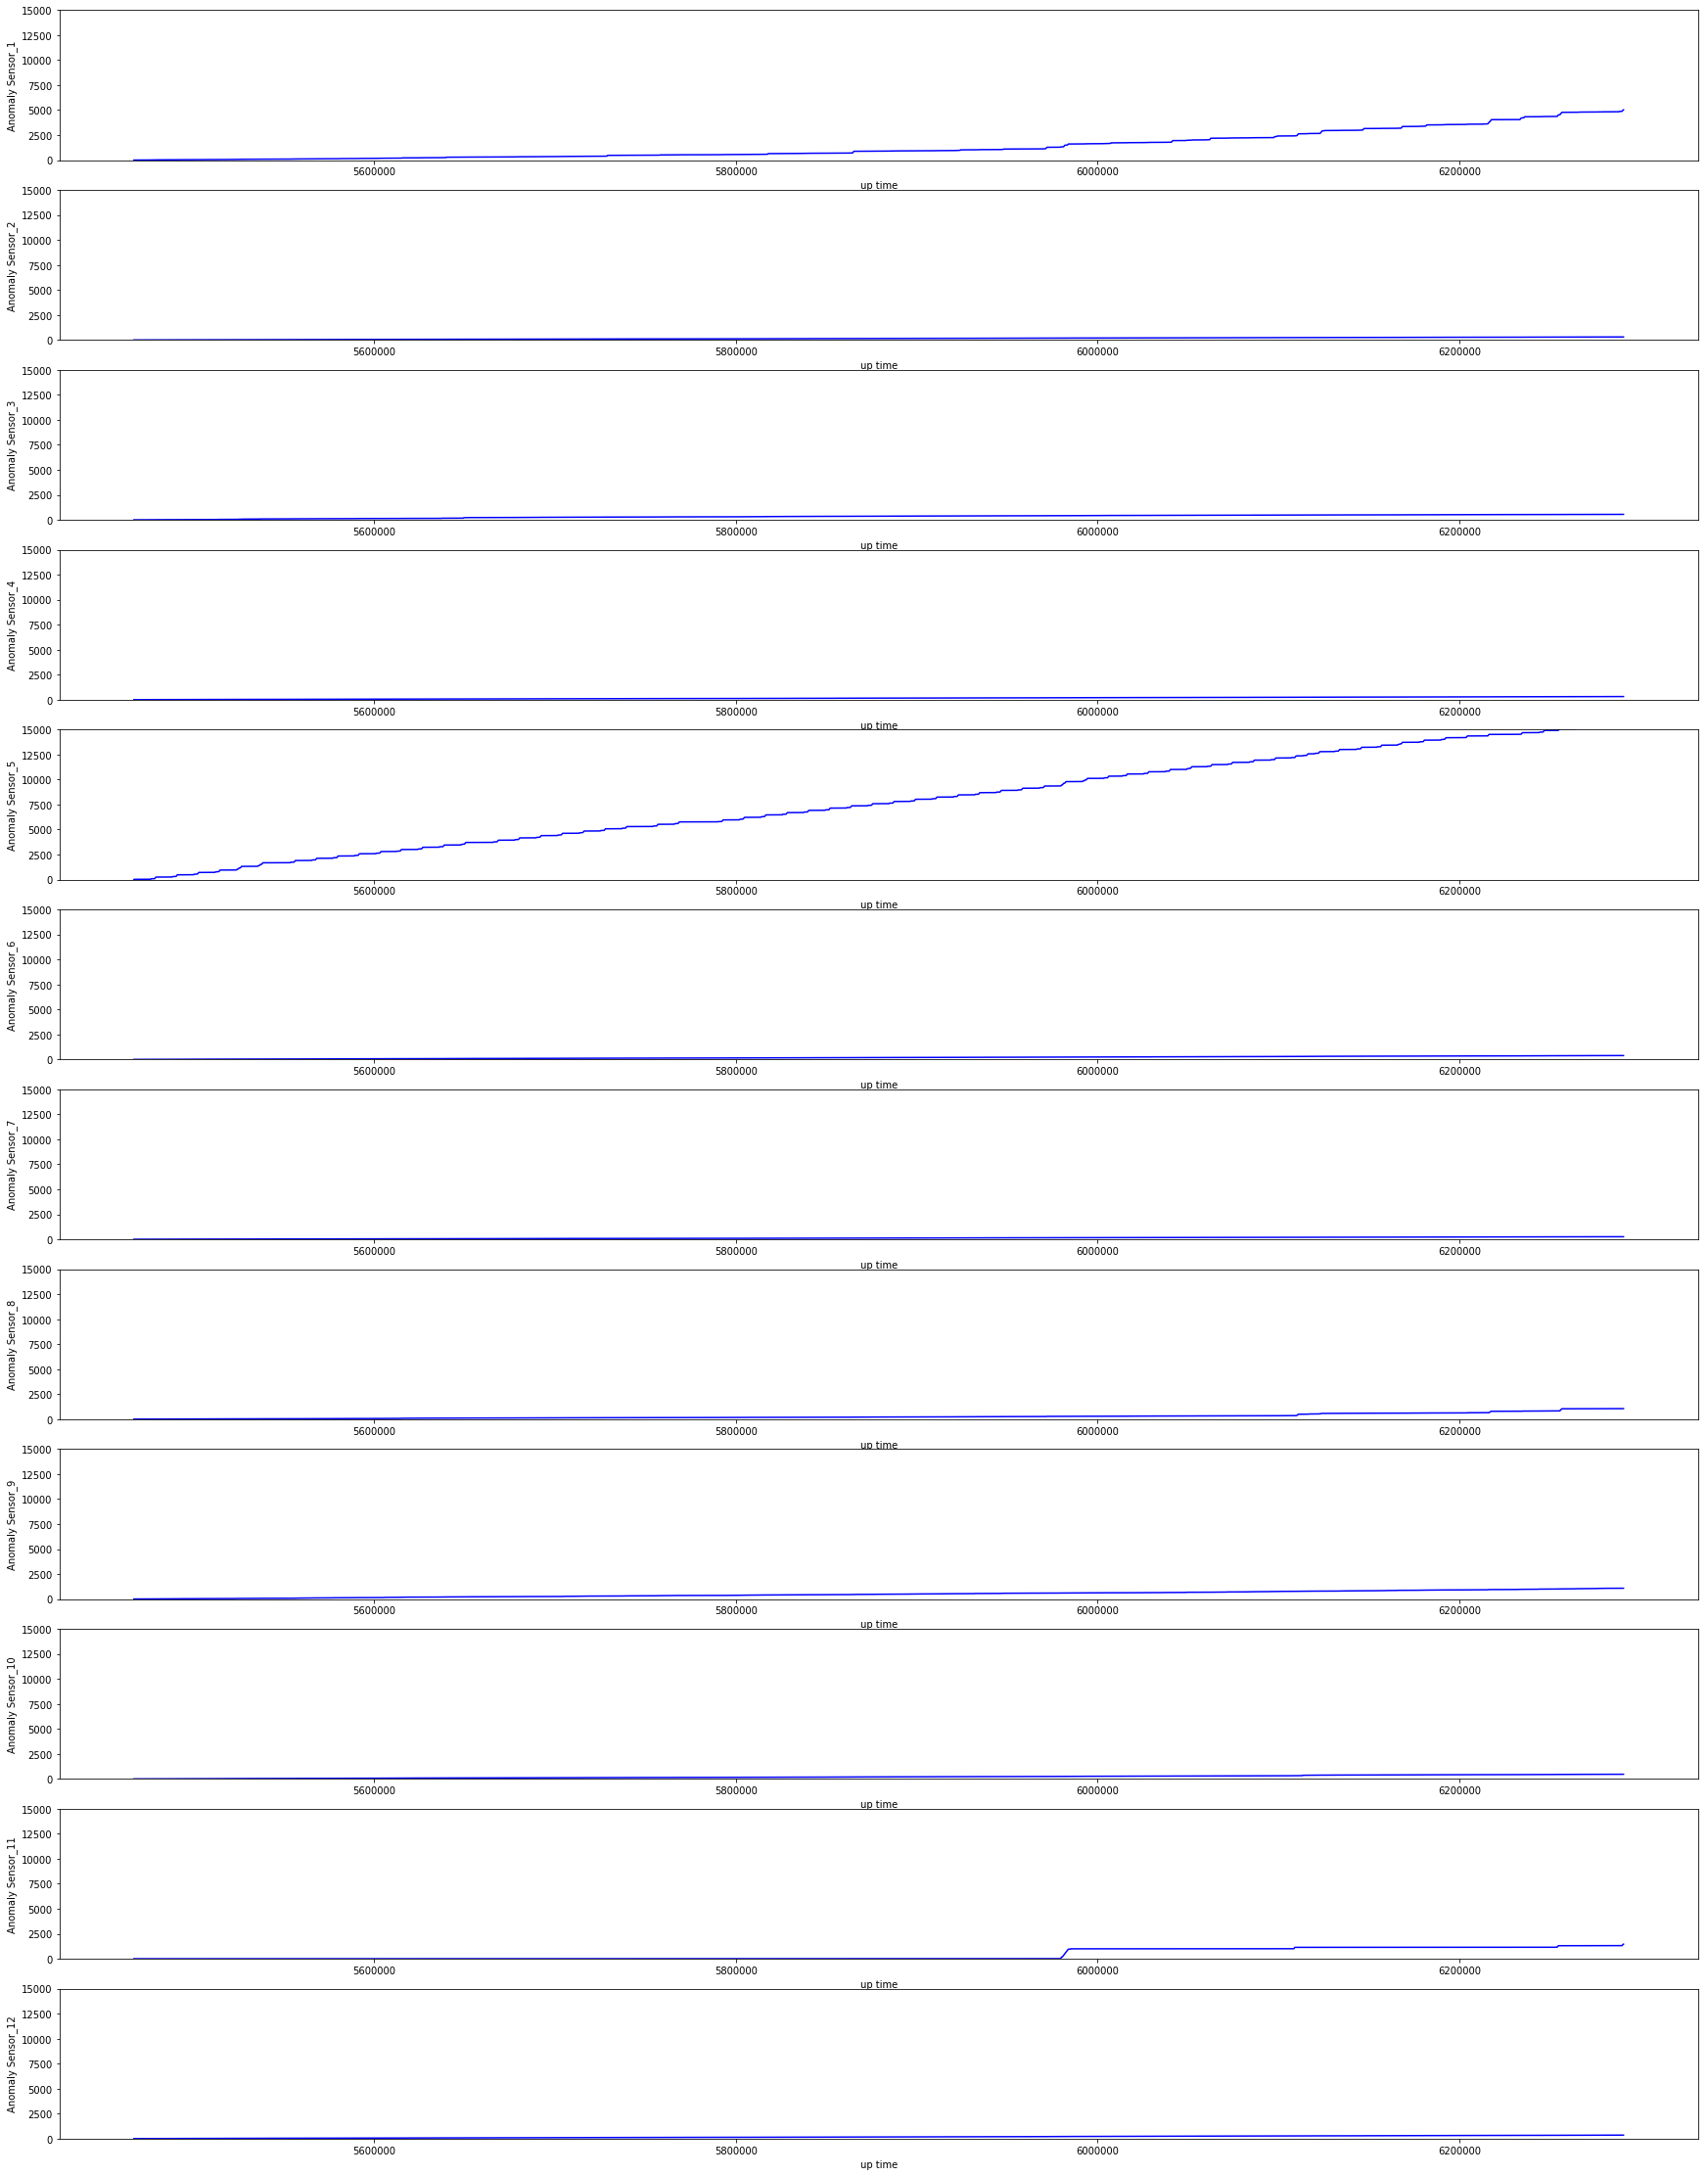

In [117]:
subset_4 = artifical_data.iloc[280000:380000,:]
failures_67_subset4 =[]
vis_anomaly_detection(subset_4, 12, 1, 13, failures_67_subset4, line=False, training=False)
plt.show()

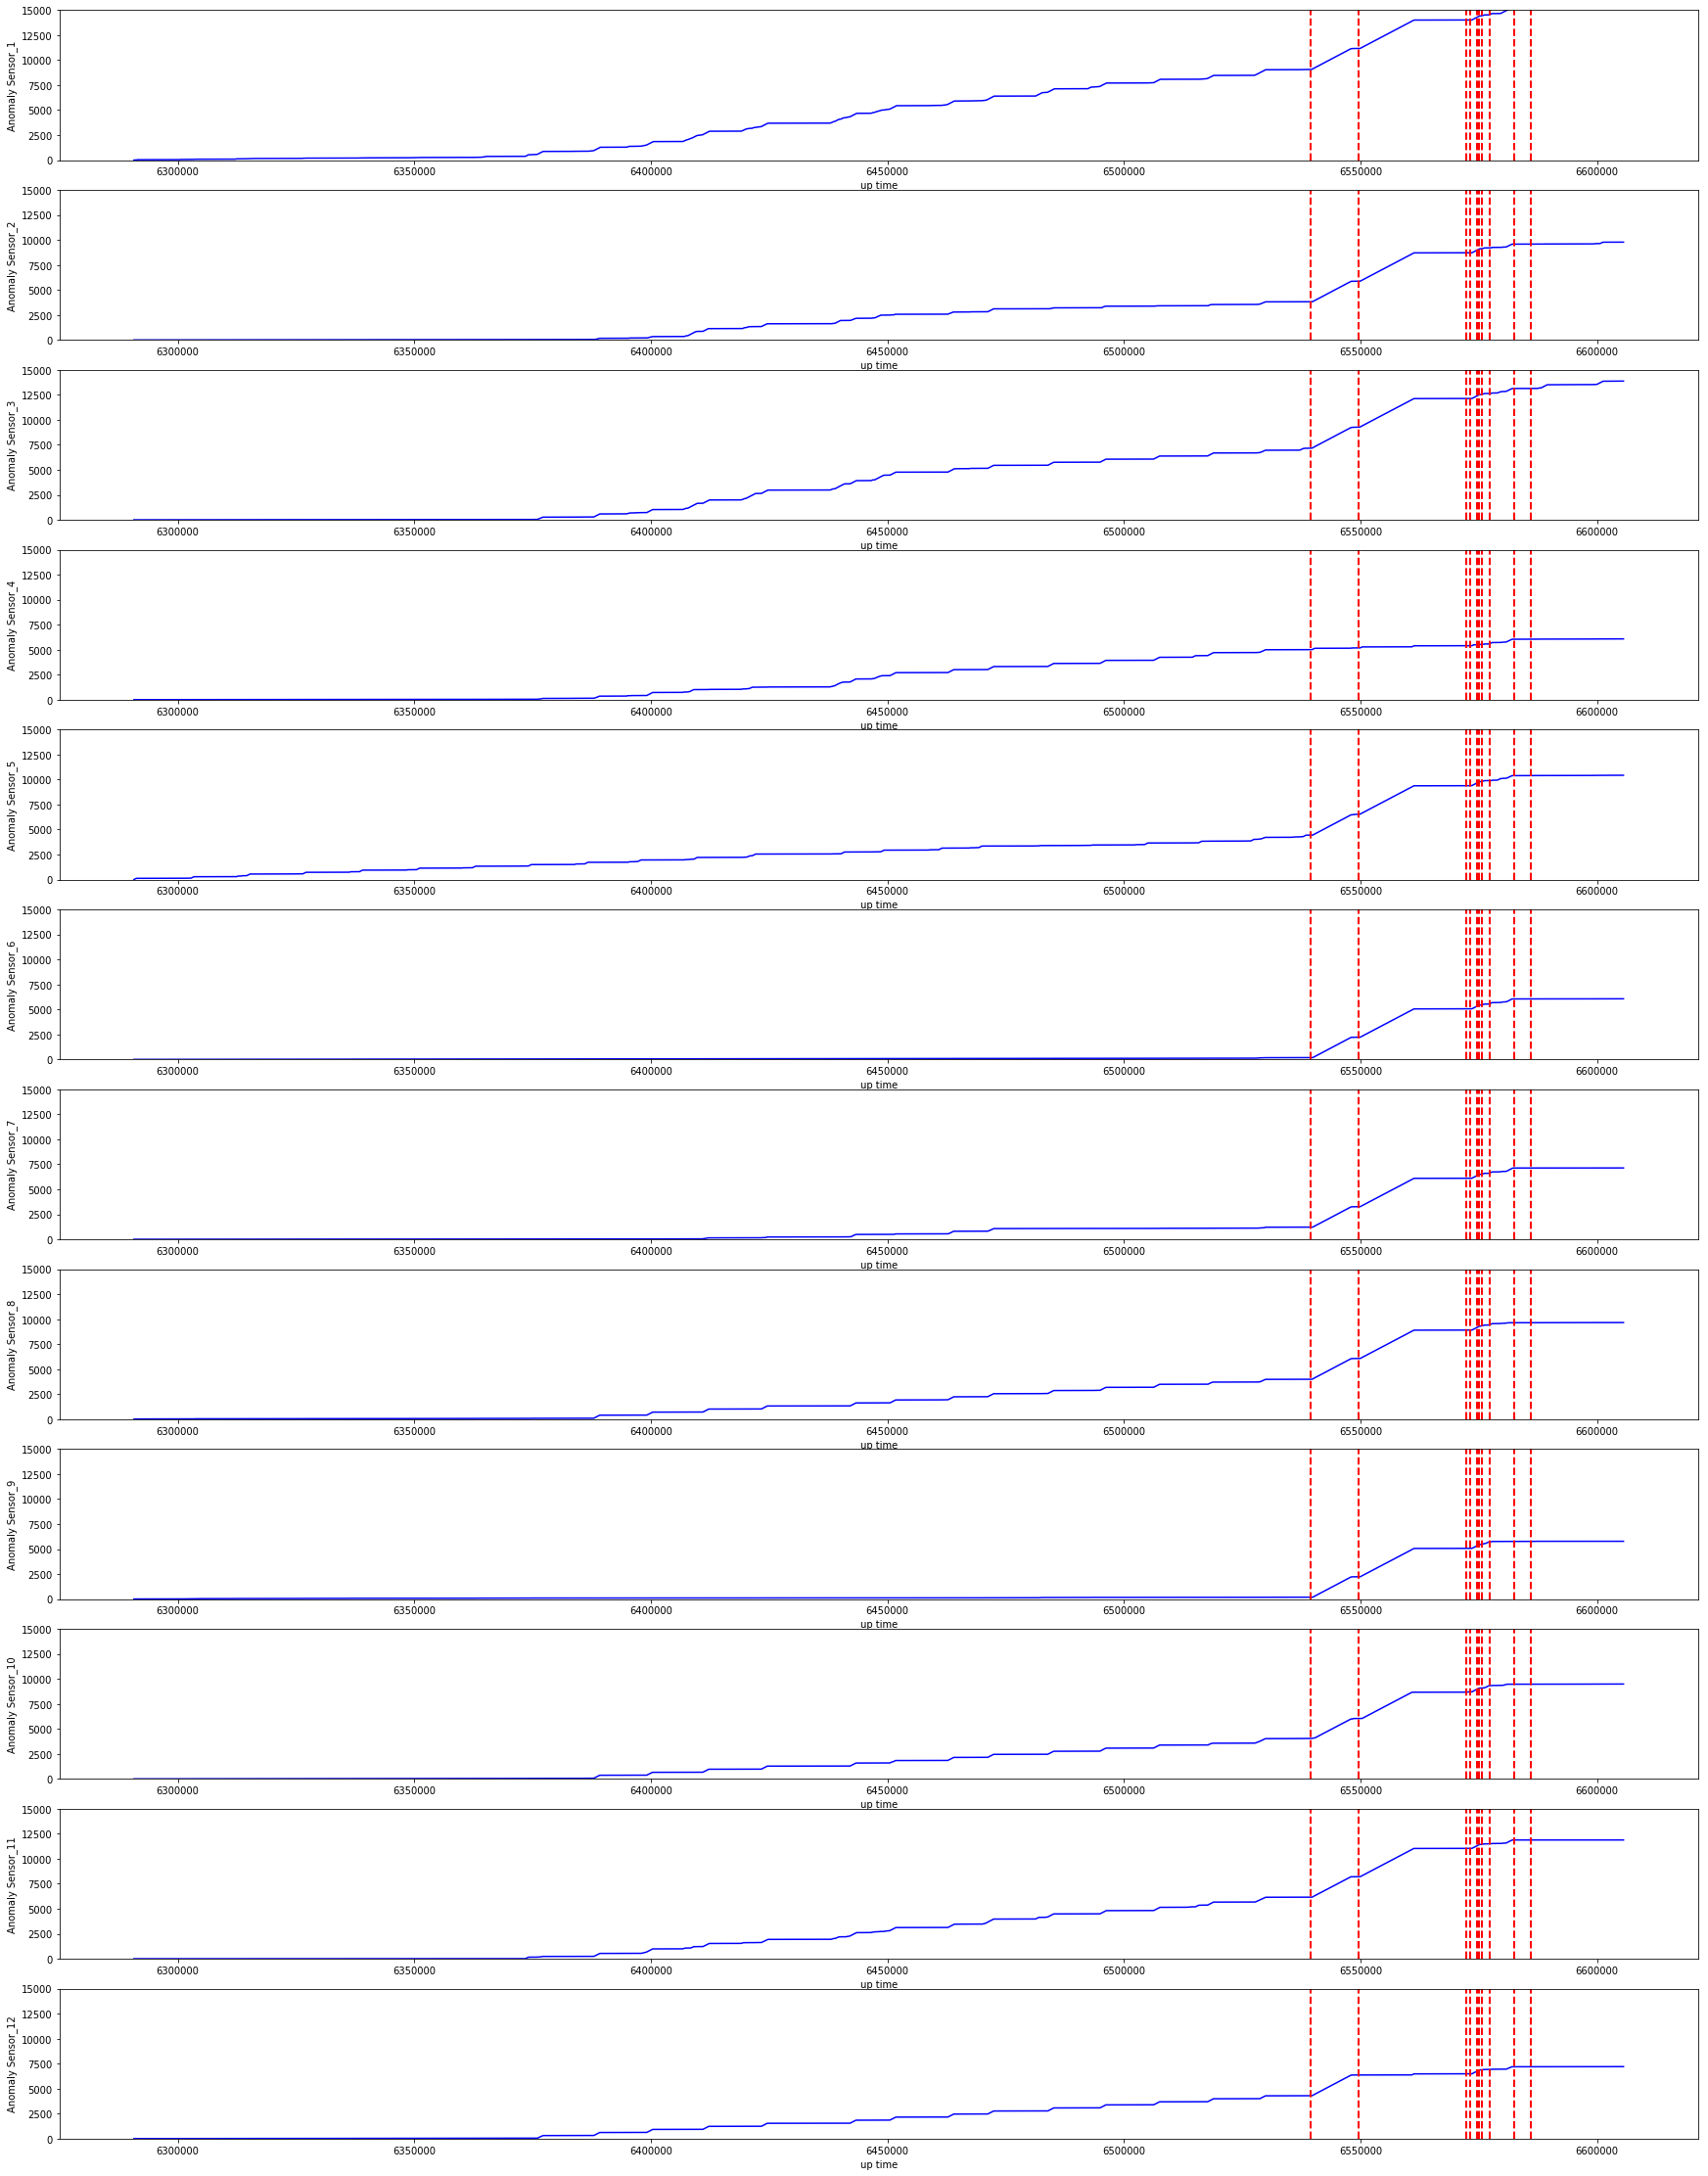

In [125]:
subset_5 = artifical_data.iloc[380000:425000,:]
failures_67_subset5 =[6539522., 6549554., 6572426., 6573162., 6574566., 6575118., 6575566., 6577254., 6582502., 6586022.]
vis_anomaly_detection(subset_5, 12, 1, 13, failures_67_subset5, line=True, training=False)
plt.show()